In [1]:
import os
import math
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Flatten
from sklearn.model_selection import train_test_split

# In[2]:
#path_name = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
#path_data = os.listdir('/kaggle/input/lgg-mri-segmentation/kaggle_3m')
#image = []
#mask = []
#name = []
#for i in path_data:
    #if i!='data.csv' and i!='README.md':
        #path_one_brain_name = os.path.join(path_name,i)
        #path_one_brain = os.listdir(path_one_brain_name)
        #for j in path_one_brain:
            #if j.endswith('.tif') and not j.endswith('_mask.tif'):
                #img = cv2.imread(os.path.join(path_one_brain_name,j))
                #img = cv2.resize(img,(128,128))
                #msk = cv2.imread(os.path.join(path_one_brain_name,j.removesuffix('.tif')+'_mask.tif'))
                #msk = cv2.resize(msk,(128,128))
                #grayImage = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
                #(thresh, msk) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
                #image.append(img)
                #mask.append(msk)
                #name.append(j)
                

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **DATA AUGMENTATIONS**

In [2]:
def obtain_data(path,split=0.2):
    images = sorted(glob(os.path.join(path,"images","*.png")))
    masks = sorted(glob(os.path.join(path,"masks","*.png")))
    split_size = int(len(images)*split)
    train_x,test_x = train_test_split(images,test_size=split_size,random_state = 42)
    train_y,test_y = train_test_split(masks,test_size=split_size,random_state = 42)
    train_x,val_x = train_test_split(train_x,test_size=split_size,random_state = 42)
    train_y,val_y = train_test_split(train_y,test_size=split_size,random_state = 42)
    return (train_x,train_y),(test_x,test_y),(val_x,val_y)

In [3]:
path = '/kaggle/input/brain-tumor-segmentation'
(x_train,y_train),(x_test,y_test),(x_val,y_val) = obtain_data(path)

In [4]:
def read_image(path,ismask = 0):
    path = path.decode()
    if(ismask == 1):
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        ret,img = cv2.threshold(img,70,255,0)
        img = img[50:490,75:460]
        img = cv2.resize(img,(128,128))
        img = img/255.0
        img = np.expand_dims(img,axis = -1)
        img = img.astype(np.float32)
    else:
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = img[50:490,75:460]
        img = cv2.resize(img,(128,128))
        img = img / 255.0
        img = img.astype(np.float32)
    return img

In [5]:
def tf_parse(x,y):
    def _parse(x,y):
        x = read_image(x)
        y = read_image(y,1)
        return x,y
    x,y = tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
    x.set_shape([128,128,3])
    y.set_shape([128,128,1])
    return x, y

In [6]:
def tf_dataset(X,Y,batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X,Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [7]:
batch_size=16
learning_r=1e-5
num_epochs=500

In [8]:
train_dataset = tf_dataset(x_train,y_train,batch=batch_size)
test_dataset = tf_dataset(x_test,y_test,batch=batch_size)
val_dataset = tf_dataset(x_val,y_val,batch=batch_size)

In [9]:
#images = np.array(images)
#masks = np.array(masks)

In [10]:
#images.shape,masks.shape

In [11]:
#from keras.utils import normalize
#masks_normal = np.expand_dims(masks,3)/255.

In [12]:
#masks_normal.shape

# **SANITY CHECK FOR OVERLAY OF IMAGE**

In [13]:
#img_plot_1 = plt.imshow(images[4],interpolation='none')
#img_plot_2 = plt.imshow(masks[4],interpolation='none',alpha=0.7)
#plt.show()

In [14]:
#from sklearn.preprocessing import LabelEncoder
#labelencoder = LabelEncoder()
#n, h, w = masks.shape
#train_masks_reshaped = masks.reshape(-1,1)
#train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
#train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

#print(np.unique(train_masks_encoded_original_shape))
#print(train_masks_encoded_original_shape.shape)

In [15]:
#train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = 3)
#print(train_masks_input.shape)

# **LOSS FUNCTIONS**

In [16]:
import keras.backend as K
smooth_iou = 0.001

def jacard_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    i = K.sum(y_true_f * y_pred_f) + smooth_iou
    u = K.sum(y_true) + K.sum(y_pred) - i + smooth_iou
    iou = i/u
    return iou
def jacard_coeff_loss(y_true,y_pred):
    return 1.0-jacard_coeff(y_true,y_pred)

In [17]:
smooth = 1e-6
def dice_coeff(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - tf.compat.v1.reduce_mean(dice_coeff(y_true, y_pred))

# **U-NET MODEL**

In [18]:

inputs = tf.keras.layers.Input((128,128,3))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)
c1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.BatchNormalization()(c1)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
c1 = tf.keras.layers.BatchNormalization()(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1)


# Layer 2

# In[8]:


c2 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.3)(c2)
c2 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
c2 = tf.keras.layers.BatchNormalization()(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2)


# Layer 3

# In[9]:


c3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
c3 = tf.keras.layers.BatchNormalization()(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3)


# Layer 4

# In[10]:


c4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
c4 = tf.keras.layers.BatchNormalization()(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)


# Layer 5

# In[11]:


c5 = tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.2)(c5)
c5 = tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5 = tf.keras.layers.BatchNormalization()(c5)


# Expansive Path:
# 
# Layer 1

# In[12]:


u6 = tf.keras.layers.Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.BatchNormalization()(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
c6 = tf.keras.layers.BatchNormalization()(c6)


# Layer 2

# In[13]:


u7 = tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.BatchNormalization()(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
c7 = tf.keras.layers.BatchNormalization()(c7)


# Layer 3

# In[14]:


u8 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
u8 = tf.keras.layers.Dropout(0.2)(u8)
c8 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.BatchNormalization()(c8)
c8 = tf.keras.layers.Dropout(0.15)(c8)
c8 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
c8 = tf.keras.layers.BatchNormalization()(c8)


# Layer 4

# In[15]:


u9 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.BatchNormalization()(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.001))(c9)
c9 = tf.keras.layers.BatchNormalization()(c9)

# Layer 5

# In[16]:

outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid',kernel_regularizer=tf.keras.regularizers.L2(0.01))(c9)


# In[17]:

#learning_rate = 0.00001
#decay_rate = learning_rate / 500

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
opt = tf.keras.optimizers.Adam(learning_rate=1e-4,
                            beta_1=0.9,
                            beta_2=0.999,
                            clipvalue=1)
model.compile(optimizer = opt,loss = dice_loss,metrics=[dice_coeff,jacard_coeff],sample_weight_mode='temporal')
model.summary()

callbacks = [tf.keras.callbacks.ModelCheckpoint('Brain_tumour_model_mask.h5',verbose=1,save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-8,patience=15,verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=60,verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(train_dataset,validation_data=val_dataset,batch_size=64,epochs=500,callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

2023-08-02 20:06:43.754095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


115/115 [==============================] - ETA: 0s - loss: 1.0087 - dice_coeff: 0.1244 - jacard_coeff: 0.0669
Epoch 1: val_loss improved from inf to 1.11078, saving model to Brain_tumour_model_mask.h5
115/115 [==============================] - 80s 477ms/step - loss: 1.0087 - dice_coeff: 0.1244 - jacard_coeff: 0.0669 - val_loss: 1.1108 - val_dice_coeff: 0.0109 - val_jacard_coeff: 0.0055 - lr: 1.0000e-04
Epoch 2/500
115/115 [==============================] - ETA: 0s - loss: 0.9312 - dice_coeff: 0.1806 - jacard_coeff: 0.0996
Epoch 2: val_loss improved from 1.11078 to 1.10140, saving model to Brain_tumour_model_mask.h5
115/115 [==============================] - 24s 206ms/step - loss: 0.9312 - dice_coeff: 0.1806 - jacard_coeff: 0.0996 - val_loss: 1.1014 - val_dice_coeff: 0.0036 - val_jacard_coeff: 0.0018 - lr: 1.0000e-04
Epoch 3/500
115/115 [==============================] - ETA: 0s - loss: 0.9033 - dice_coeff: 0.1935 - jacard_coeff: 0.1076
Epoch 3: val_loss improved from 1.10140 to 1.07474

# **OUTPUT EVALUATION**

In [19]:
model.compile(optimizer = opt, loss = dice_loss, metrics = [dice_coeff,jacard_coeff , 'accuracy'])
print("Evaluate on test data")
results = model.evaluate(test_dataset,batch_size = batch_size)

Evaluate on test data
39/39 [==============================] - 25s 320ms/step - loss: 0.2271 - dice_coeff: 0.7690 - jacard_coeff: 0.6380 - accuracy: 0.9833


In [20]:
model_1 = tf.keras.models.load_model('/kaggle/input/model-exp/Brain_tumour_model_mask.h5',custom_objects={'dice_loss':                   
dice_loss,'dice_coeff':dice_coeff})

1/1 [==============================] - 1s 641ms/step


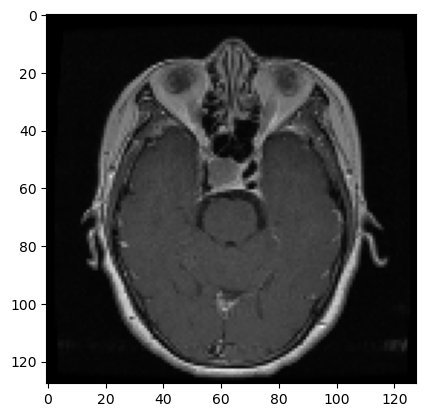

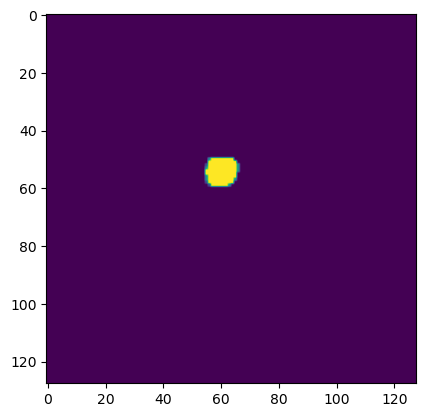

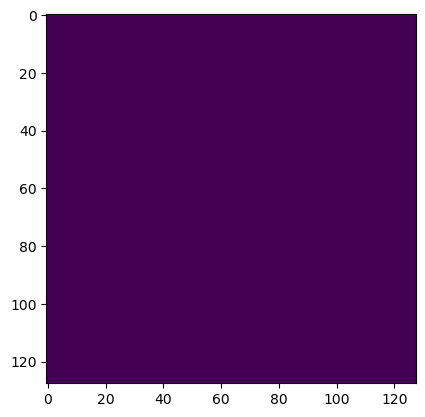

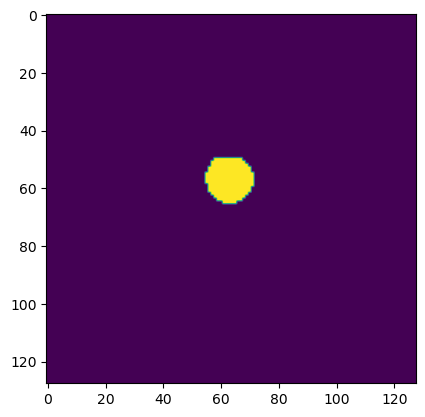

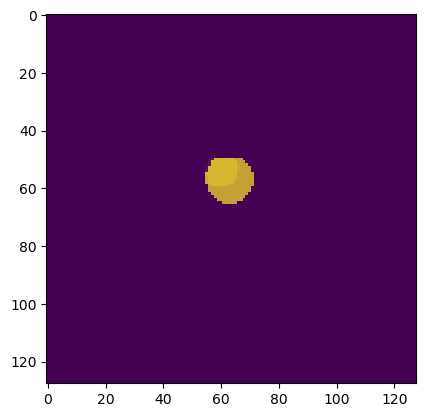

In [21]:
num = 1
test_img = cv2.imread(x_train[num],cv2.IMREAD_COLOR)
x1 = cv2.resize(test_img , (128,128))
x_1 = x1/255.0
x_1 = np.expand_dims(x_1,axis=0)
mask = cv2.imread(y_train[num],cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask,(128,128))
y_pred = model.predict(x_1)
y_pred = np.squeeze(y_pred , axis = 0)
#y_pred = y_pred>=0.5
y_pred_1 = model_1.predict(x_1)
y_pred_1 = np.squeeze(y_pred_1 , axis = 0)
y_pred_1 = y_pred_1>=0.75
img_plt_1 = plt.imshow(x1)
plt.show()
img_plot_2 = plt.imshow(mask)
plt.show()
img_plot_3 = plt.imshow(y_pred)
plt.show()
img_plot_3_1 = plt.imshow(y_pred_1)
plt.show()
img_plot_4 = plt.imshow(mask,interpolation='none')
img_plot_5 = plt.imshow(y_pred,interpolation='none',alpha=0.7)
img_plot_6 = plt.imshow(y_pred_1,interpolation='none',alpha=0.7)
plt.show()